In [1]:
import scCube
from scCube import scCube
from scCube.visualization import *
from scCube.utils import *
from matplotlib.pyplot import rc_context
import pandas as pd
import scanpy as sc
import numpy as np
import warnings
import time
warnings.filterwarnings("ignore")

/home/qjy/anaconda3/envs/sccube/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = scCube()

In [3]:
sc_adata = sc.read_h5ad('/home/qjy/workspace/scCube/data/sc/Tabula_Muris_TM_facs_Brain_Non_Myeloid_adata.h5ad')

In [4]:
sc_adata.layers["log_transformed"] = sc_adata.X
sc_data = sc_adata.to_df(layer="log_transformed").T
sc_meta = sc_adata.obs

In [5]:
sc_meta['Cell_type'].value_counts()

oligodendrocyte                   1574
endothelial cell                   715
astrocyte                          432
neuron                             281
oligodendrocyte precursor cell     203
brain pericyte                     156
Bergmann glial cell                 40
Name: Cell_type, dtype: int64

In [6]:
# generate user-specified number of cells or cell types
generate_sc_meta, generate_sc_data = model.load_vae_and_generate_cell(
    sc_adata=sc_adata,
    celltype_key='Cell_type',
    cell_key='Cell',
    target_num={'oligodendrocyte': 2000, 'endothelial cell': 600, 'astrocyte': 500, 'neuron': 500, 'oligodendrocyte precursor cell': 100, 'brain pericyte': 100, 'Bergmann glial cell': 0},
    hidden_size=128,
    load_path='/home/qjy/workspace/scCube/save_model/Tabula_Muris_TM_facs_Brain_Non_Myeloid_epoch10000.pth',
    used_device='cuda:1')

generating by the targeted proportion of cell types...
loading model from /home/qjy/workspace/scCube/save_model/Tabula_Muris_TM_facs_Brain_Non_Myeloid_epoch10000.pth
vae loading done!


Generate Epoch: 1: 100%|██████████| 3800/3800 [00:01<00:00, 3198.66it/s]


generated done!
data have been prepared!


In [7]:
generate_sc_meta['Cell_type'].value_counts()

oligodendrocyte                   2000
endothelial cell                   600
neuron                             500
astrocyte                          500
oligodendrocyte precursor cell     100
brain pericyte                     100
Name: Cell_type, dtype: int64

In [8]:
sc.pp.highly_variable_genes(sc_adata, flavor="seurat_v3", n_top_genes=2000)
sc_adata = sc_adata[:, sc_adata.var.highly_variable]
sc.pp.scale(sc_adata, max_value=10)
sc.tl.pca(sc_adata, svd_solver='arpack')
sc.pp.neighbors(sc_adata)
sc.tl.umap(sc_adata)

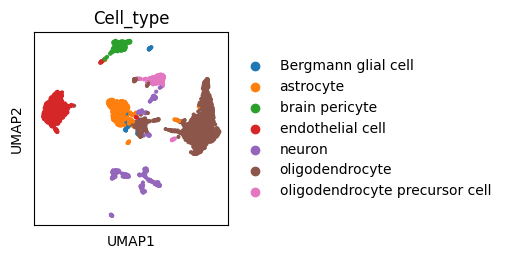

In [9]:
with rc_context({'figure.figsize': (2.5, 2.5)}):
    sc.pl.umap(sc_adata, color='Cell_type')

In [10]:
sc_adata_generate = model.pre_process(sc_data=generate_sc_data, 
                                      sc_meta=generate_sc_meta,
                                      is_normalized=True)

sc.pp.highly_variable_genes(sc_adata_generate, flavor="seurat_v3", n_top_genes=2000)
sc_adata_generate = sc_adata_generate[:, sc_adata_generate.var.highly_variable]
sc.pp.scale(sc_adata_generate, max_value=10)
sc.tl.pca(sc_adata_generate, svd_solver='arpack')
sc.pp.neighbors(sc_adata_generate)
sc.tl.umap(sc_adata_generate)

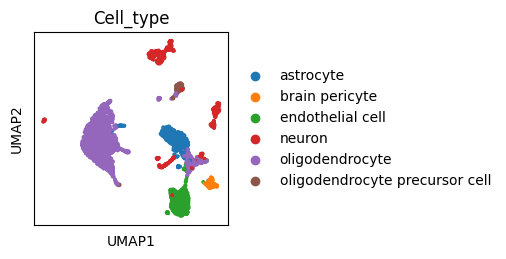

In [11]:
with rc_context({'figure.figsize': (2.5, 2.5)}):
    sc.pl.umap(sc_adata_generate, color='Cell_type')

In [12]:
adata_concat = sc_adata.concatenate(sc_adata_generate, batch_categories=['real', 'generate'])
sc.tl.pca(adata_concat)
# sc.external.pp.bbknn(adata_concat, batch_key='batch')  # running bbknn 1.3.6
sc.pp.neighbors(adata_concat)
sc.tl.umap(adata_concat)

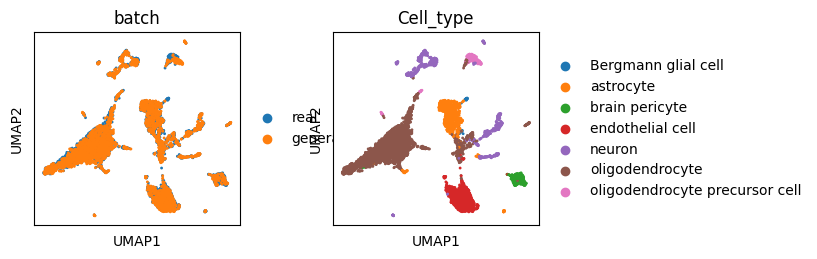

In [13]:
with rc_context({'figure.figsize': (2.5, 2.5)}):
    sc.pl.umap(adata_concat, color=['batch', 'Cell_type'])

In [14]:
# astrocyte, neuron have specified spatial patterns, other cell types follow uniform distributions
generate_sc_data, generate_sc_meta_new, st_data, st_meta, st_index = model.generate_spatial_data_random(
    generate_sc_data=generate_sc_data,
    generate_sc_meta=generate_sc_meta,
    set_seed=True,
    seed=12345,
    spatial_cell_type=['astrocyte', 'neuron'],
    spatial_dim=2,
    spatial_size=30,
    delta=10,
    lamda=0.75,
    is_spot=True,
    gene_type='whole',
    platform='Visium',
    n_cell=10
)

generating spatial coordinates of single cells...
generating spatial patterns of selected 2 cell types...
generating spot-based ST data with 10 cells per spot...
generating with the spot layout and neighborhood structure of Visium (hex)...
generating with whole genes...


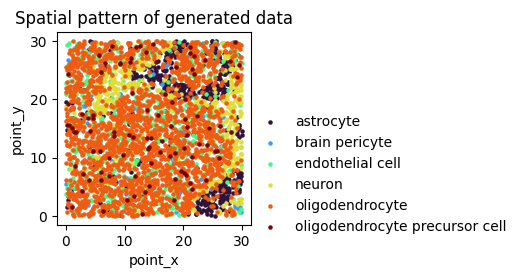

In [15]:
p = plot_spatial_pattern_scatter(
    obj=generate_sc_meta_new,
    figwidth=2.5,
    figheight=2.5,
    dim=2,
    x="point_x",
    y="point_y",
    label='Cell_type',
    colormap='turbo',
    size=5,
    alpha=1)

plt.show(p)

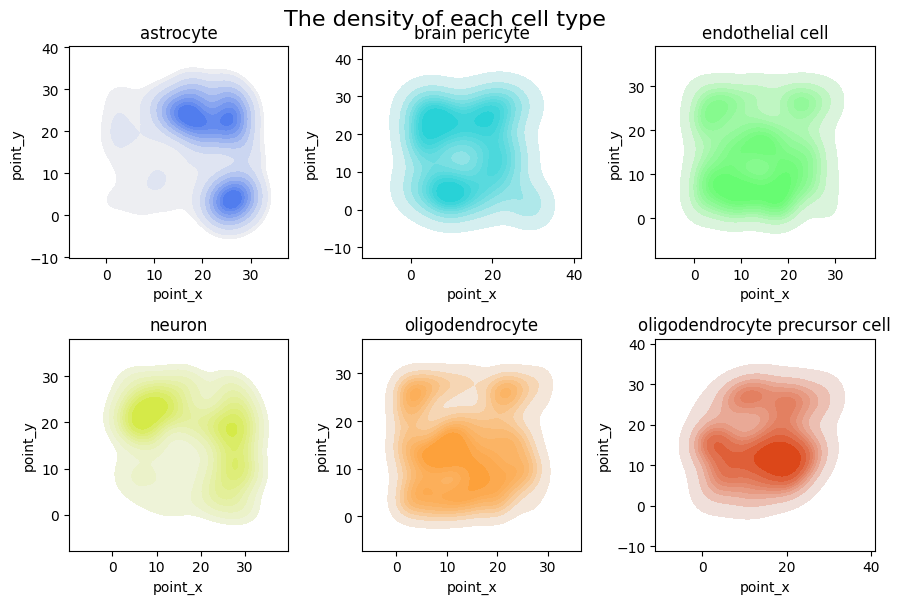

In [16]:
p = plot_spatial_pattern_density(
    obj=generate_sc_meta_new,
    figwidth=9,
    figheight=6,
    x="point_x",
    y="point_y",
    show_celltype=None,
    label='Cell_type',
    colormap='turbo',
    fill=True)

plt.show(p)

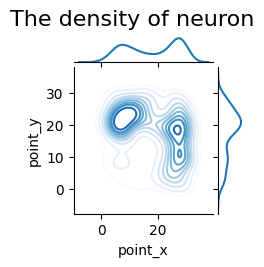

In [18]:
p = plot_spatial_pattern_density(
    obj=generate_sc_meta_new,
    figwidth=5,
    figheight=2.5,
    x="point_x",
    y="point_y",
    show_celltype='neuron',
    label='Cell_type',
    colormap='Blues',
    fill=False)

plt.show(p)

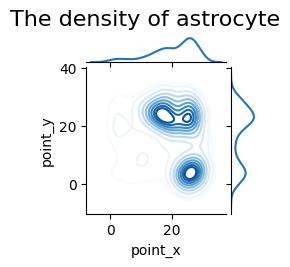

In [19]:
p = plot_spatial_pattern_density(
    obj=generate_sc_meta_new,
    figwidth=5,
    figheight=2.5,
    x="point_x",
    y="point_y",
    show_celltype='astrocyte',
    label='Cell_type',
    colormap='Blues',
    fill=False)

plt.show(p)

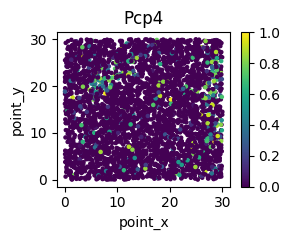

In [22]:
# Pcp4 -- neuron; Slc6a11 -- astrocyte
p = plot_gene_scatter(
    data=generate_sc_data,
    obj=generate_sc_meta_new,
    figwidth=3,
    figheight=2.5,
    dim=2,
    label='Cell',
    normalize=True,
    x="point_x",
    y="point_y",
    show_gene="Pcp4",
    colormap='viridis',
    size=5,
    alpha=1
)

plt.show(p)

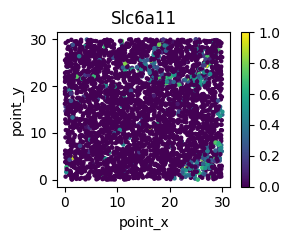

In [23]:
p = plot_gene_scatter(
    data=generate_sc_data,
    obj=generate_sc_meta_new,
    figwidth=3,
    figheight=2.5,
    dim=2,
    label='Cell',
    normalize=True,
    x="point_x",
    y="point_y",
    show_gene="Slc6a11",
    colormap='viridis',
    size=5,
    alpha=1
)

plt.show(p)

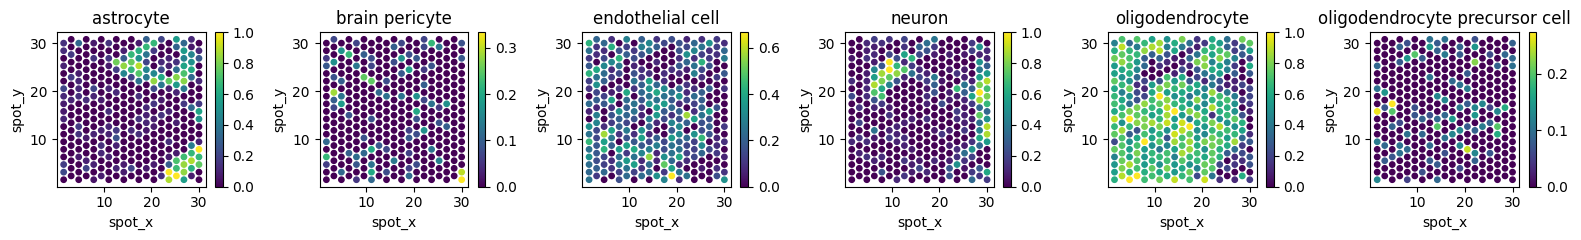

In [34]:
prop = calculate_spot_prop(
    obj=st_index,
    cell_id='Cell',
    label='Cell_type',
    spot_id='spot')
    
p = plot_spot_prop(
    obj=prop,
    figwidth=16,
    figheight=2.5,
    x="spot_x",
    y="spot_y",
    colormap='viridis',
    show_celltype=list(set(generate_sc_meta_new.Cell_type)),
    size=15,
    alpha=1)

plt.show(p)

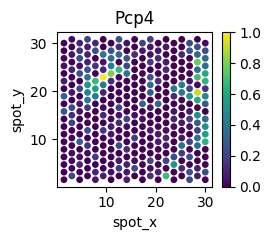

In [38]:
p = plot_gene_scatter(
    data=st_data,
    obj=st_meta,
    figwidth=2.8,
    figheight=2.5,
    dim=2,
    label='spot',
    normalize=True,
    x="spot_x",
    y="spot_y",
    show_gene="Pcp4",
    colormap='viridis',
    size=15,
    alpha=1
)
plt.show(p)

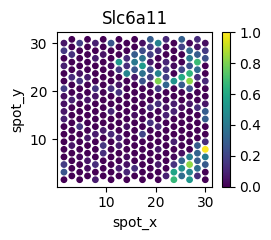

In [39]:
p = plot_gene_scatter(
    data=st_data,
    obj=st_meta,
    figwidth=2.8,
    figheight=2.5,
    dim=2,
    label='spot',
    normalize=True,
    x="spot_x",
    y="spot_y",
    show_gene="Slc6a11",
    colormap='viridis',
    size=15,
    alpha=1
)
plt.show(p)